# Tratando dados ausentes

Normalmente é muito empolgante começar uma nova modelagem de machine learning **\o/**

Mas quando descobrimos que nosso principal dataset tem um monte de dados faltando, bate uma certa preocupação...  
São os temidos **"missing data"** ou **"missing values"**.

<img src="images/dados_ausentes_learnison.jpg" align="left" width="200">
Nosso amigo Learnison está passando exatamente por isso:<br>
─ O que farei com tantos buracos nos dados?
<br><br>
O primeiro impulso foi de simplesmente remover todas as linhas e colunas com dados ausentes.<br>
Mas logo reconsiderou:<br>
─ Isso parece radical. Ou simplista...  
Talvez seja melhor preencher com algum valor default.
<br><br>
Uma aflição, entretanto, continuou o incomodando:<br>
─ Uma decisão ruim poderá comprometer a qualidade do meu modelo...

Então respirou fundo, meditou um pouco e decidiu abordar o problema com a mente *zen* agitação...  
Vamos acompanhá-lo neste episódio.

## Será mesmo?
Pra começar, é bom confirmar se o dataset foi baixado corretamente da origem.  
Uma **simples verificação** pode evitar muitas horas de dor de cabeça infrutíferas.
* Conferir se o arquivo não se corrompeu durante a transferência.
* Se o arquivo não for grande, baixar novamente e comparar.
* Se o dataset veio de um banco de dados, consultar diretamente o banco e verificar se os dados também estão ausentes lá.

### Sim :/
Porém, existe a indesejada possibilidade de os dados estarem realmente ausentes.  
Foi o que ocorreu neste caso.

> **OBS:** Como exemplo, usaremos o popular dataset do naufrágio do Titanic.
> 
> No site do Kaggle, o dataset está dividido em arquivos separados (treino e teste), prontos para uso na machine learning. 
Mas podemos baixar o arquivo único disponível na URL: https://hbiostat.org/data/repo/titanic3.xls
> 
> E para as descrições dos atributos, consultaremos o Kaggle: https://www.kaggle.com/c/titanic/data

<img src="images/icons8-pesquisar-96.png" width="50">

## Desvendando os dados

In [1]:
import pandas as pd

In [122]:
url = "https://hbiostat.org/data/repo/titanic3.xls"
df = pd.read_excel(url)

In [123]:
df.shape

(1309, 14)

### Prazer em conhecê-los!
Novo dataset, novas surpresas! Agradáveis ou não...

Depois de carregado em um dataframe Pandas, sabemos o seu tamanho com o **shape** .    
1309 linhas e 14 colunas

E para conhecer os atributos e data types, usamos o método **info()**.

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


Além dos nomes e dtypes dos atributos, o info() também diz quantos valores não-nulos existem em cada coluna e, no final, também informa o uso de memória do dataframe.

**Obs 1:** Para saber o uso completo de memória, usar **df.info(memory_usage="deep")**.

**Obs 2:** Usar o **df.describe()** para uma visão geral estatística dos valores **numéricos**.

### Ausentes, quem são vocês?
Pelo info() sabemos que existem 7 atributos com lacunas nos dados.  
Confirmando:

In [125]:
print("Quais:", df.columns[df.isnull().any()])
print("Quantos:", df.isnull().any().sum())

Quais: Index(['age', 'fare', 'cabin', 'embarked', 'boat', 'body', 'home.dest'], dtype='object')
Quantos: 7


É importante entender exatamente a que se refere cada atributo.  
Às vezes o nome não diz muita coisa sobre o conteúdo.  
Por isso, consulta-se o dicionário de dados do dataset:
* age - idade do passageiro em anos
* fare - preço da passagem
* cabin - número da cabine do passageiro
* embarked - porto onde embarcou (C = Cherbourg, Q = Queenstown, S = Southampton)
* boat - número do bote salva-vidas (caso tenha sobrevivido)
* body - número de identificação do corpo (caso tenha morrido e recuperado)
* home.dest - cidades origem/destino

<img src="images/icons8-pyramid-toy-96.png" width="60">

## Tratando os dados

Conhecendo melhor os atributos com dados ausentes, pode-se remover aqueles que não serão úteis para a predição no modelo de machine learning. Os que chamam a atenção inicialmente são o "**boat**" e "**body**".

Eles são chamados de **leaky features** (atributos com vazamento de informação). Ou seja, o número do bote ou o número do corpo predizem, indiretamente, que o passageiro sobreviveu ou morreu. Logo, não devem ser usados no modelo. Já existe a feature com esta informação determinada, o atributo "survived".

### Remover
Relembrando os principais usos do método dropna() do Pandas:
* df.dropna() - remove todas as linhas que possuem, ao menos, um dado ausente (NaN).
* df.dropna(how='all') - remove todas as linhas em que **todos** conteúdos das colunas forem NaN.

Na remoção de linhas, para considerar somente um subconjunto de colunas, usar **subset**:
* df.dropna(subset=['col1', 'col2'...])

Para remover colunas, especificar o axis (eixo) 1 (columns):
* df.dropna(axis=1) - remove todas as colunas que possuem, ao menos, um dado ausente (NaN).
* df.dropna(axis=1, how='all') - remove todas as colunas em que **todos** conteúdos das linhas forem NaN.

<img src="images/icons8-recortar-96.png" width="50">

Existem duas maneiras de remover as colunas 'boat' e 'body'.

In [128]:
df.drop(['boat', 'body'], axis=1)    # Ou: df.drop(columns=['boat', 'body'])

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON"
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,"Zabour, Miss. Hileni",female,14.5000,1,0,2665,14.4542,NaN,C,NaN
1305,3,0,"Zabour, Miss. Thamine",female,NaN,1,0,2665,14.4542,NaN,C,NaN
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5000,0,0,2656,7.2250,NaN,C,NaN
1307,3,0,"Zakarian, Mr. Ortin",male,27.0000,0,0,2670,7.2250,NaN,C,NaN


Colunas removidas?  
Vamos conferir com o shape.

In [8]:
df.shape

(1309, 14)

<img src="images/icons8-grito-96.png" width="70">

Parece que não funcionou... Continuam as 14 colunas iniciais do dataframe!

É que alguns métodos do Pandas retornam uma cópia do dataframe, ou seja, não modificam o dataframe original.  
Mas há duas maneiras simples de resolver isso.

In [129]:
df = df.drop(['boat', 'body'], axis=1)
df.shape

# Ou: df.drop(['boat', 'body'], axis=1, inplace=True)

(1309, 12)

Agora sim, removidas!

Mas restam ainda 5 atributos com dados ausentes.
* age - idade do passageiro em anos
* fare - preço da passagem
* cabin - número da cabine do passageiro
* embarked - porto onde embarcou (C = Cherbourg, Q = Queenstown, S = Southampton)
* home.dest - cidades origem/destino

### Preencher

<img src="images/icons8-chá-96.png" width="60">

Para eles, queremos saber:

* Qual a quantidade de dados ausentes de cada um?  
* E quantos são em valor absoluto e em percentual?

In [10]:
df[['age', 'fare', 'cabin', 'embarked', 'home.dest']].isnull().agg(['sum', 'mean']).T

,sum,mean
age,263.0,0.200917
fare,1.0,0.000764
cabin,1014.0,0.774637
embarked,2.0,0.001528
home.dest,564.0,0.430863


Alguns são mais preocupantes...  
"**cabin**" tem 77% de dados não informados e "**home.dest**" 43%.

Já o percentual de "**age**" não é tão alto, mas são 20% dos passageiros sem informação de idade.  
E é uma variável importante para o modelo.  
Presume-se que um jovem teria mais chance de sobreviver do que um idoso ou uma criança.  

#### Age
Como estará a distribuição das idades em relação ao conjunto de dados completo?  
Dá para ver num **histograma**.

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

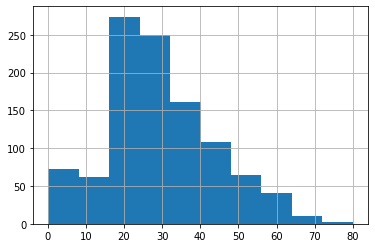

In [12]:
df['age'].hist(bins=10)
plt.show()

Para visualizar o quanto as idades ausentes afetam o conjunto completo, é possível usar um artifício.  
Substituímos os valores nulos por outro bem distante, por exemplo, -100. 

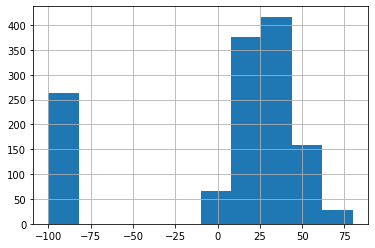

In [130]:
import numpy as np
df['age'].replace(np.nan, -100).hist(bins=10)
plt.show()

**Hipóteses**:
* Será que as idades não informadas referem-se a um determinado padrão de passageiros?  
* Ou a um determinado padrão no dataset? Por exemplo, somente os últimos registros?  
* Ou estão ausentes de forma aleatória?  
* Será que houve displicência quando cadastraram as datas de nascimento dos passageiros?

Existe um gráfico que ilustra bem a distribuição dos dados ausentes. Fica na bilioteca "missingno".

In [14]:
import missingno as msno
import warnings
warnings.filterwarnings('ignore')

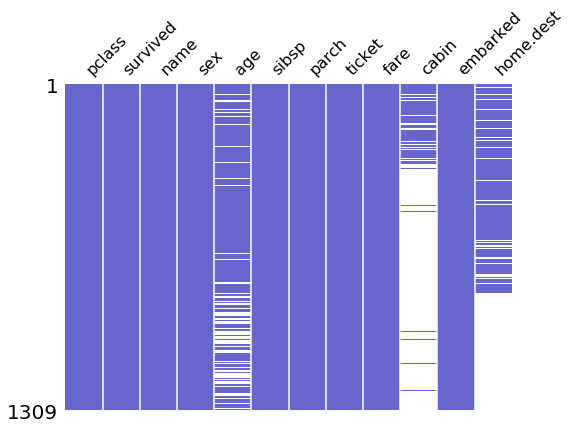

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
msno.matrix(df, color=(0.4, 0.4, 0.8), ax=ax)
plt.show()

<img src="images/icons8-sherlock-holmes-96.png" width="60">

Percebe-se que as lacunas das idades são meio aleatórias.  
Então podemos preenchê-las com algum valor que colabore com o machine learning.

Mas qual?
* 0 (zero) poderá distorcer a realidade... 20% de bebês a bordo?
* média das idades dos passageiros? Parece razoável.

Preenche-se os valores nulos com o método **fillna()** do Pandas.  
O valor preenchido pode ser fixo ou algo calculado.  
Neste caso, será a média da coluna "age".

In [134]:
df['age'].fillna((df['age'].mean()), inplace=True)
df['age'].isnull().sum()

0

#### Fare
O atributo "fare" (preço da passagem) só tem 1 ausente.  

Parece indiferente preencher com o valor médio ou simplesmente remover a linha.  
Não deve impactar o modelo.  

Desta vez, ao invés do Pandas, usaremos a classe **SimpleImputer** da biblioteca **scikit-learn**.

In [135]:
from sklearn.impute import SimpleImputer

In [136]:
imp = SimpleImputer()
df[['fare']] = imp.fit_transform(df[['fare']])    # Obs: usar dataframe e não series como parâmetro
df['fare'].isnull().sum()

0

> **Obs:** Por default, os valores nulos (np.nan) serão preenchidos com a média (strategy='mean'). Outras opções são:
> * SimpleImputer(strategy='most_frequent')
> * SimpleImputer(strategy='median')
> * SimpleImputer(strategy='constant', fill_value=99)

#### Cabin

<img src="images/titanic_design.jpg" width="500">

In [137]:
df['cabin'].isnull().sum()

1014

É difícil imaginar porque a informação do número da cabine está ausente para 1014 passageiros.

A localização da cabine poderá influenciar se o passageiro sobreviveu ou não (vide imagem acima do Titanic).  
Ou seja, teoricamente, é um atributo útil para o modelo.

Para analisar, cria-se uma nova coluna no dataframe do tipo booleana.  
O conteúdo será true ou false, conforme o passageiro tenha ou não cabine.

In [138]:
df['with_cabin'] = df['cabin'].notnull()
df['with_cabin'].value_counts()

False    1014
True      295
Name: with_cabin, dtype: int64

Será que realmente quem não tinha cabine teve menor chance de sobreviver?  
Pode-se agrupar o dataframe pelos 2 atributos ("with_cabin" e "survived") e ver os quantitativos.

In [139]:
# Retorna uma series multiindex com os totais agrupados pelas 2 colunas
group = df.groupby(['with_cabin', 'survived'])['with_cabin'].count()
group

with_cabin  survived
False       0           707
            1           307
True        0           102
            1           193
Name: with_cabin, dtype: int64

Vê-se que, dos 295 que tinham cabine, 193 sobreviveram.  
Logo, não foram tão superiores (193/295 = 65%).

Já dos passageiros que não tinham cabine, é difícil afirmar algo.   
Não sabemos se não tinham mesmo, ou se simplesmente os dados não foram preenchidos.

<img src="images/icons8-gráfico-de-barras-96.png" width="60">

É bom observar isso visualmente.  
A vantagem do gráfico é que ele facilita o ***insight*** sobre os dados, enquanto que os números exigem algum esforço de interpretação.

Para colocar esses dados num gráfico de barras, primeiro transformamos o resultado da variável "group".  
Como é uma série multindex, uma maneira é pivotear o segundo index (survived) para coluna.  
Isso pode ser feito com o método **unstack()** do Pandas. Por default ele pivoteia o último level do index (-1):

In [140]:
# Pivoteia o último index (survived) para coluna
survived_pivoted = group.unstack()
survived_pivoted

survived,0,1
with_cabin,,
False,707,307
True,102,193


In [141]:
survived_pivoted.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2 entries, False to True
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       2 non-null      int64
 1   1       2 non-null      int64
dtypes: int64(2)
memory usage: 48.0+ bytes


Agora pode ser aplicado no gráfico de barras.

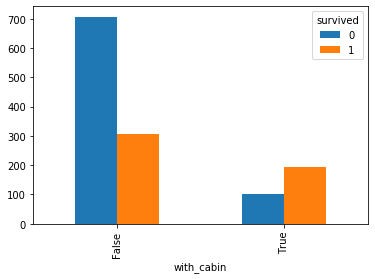

In [24]:
survived_pivoted.plot.bar()
plt.show()

Há uma forma mais simples de gerar este dataframe agrupado e pivoteado.  
Usando o "**crosstab**" do Pandas.

In [25]:
crosstab = pd.crosstab(df['with_cabin'], df['survived'])
crosstab

survived,0,1
with_cabin,,
False,707,307
True,102,193


O gráfico fica igual.

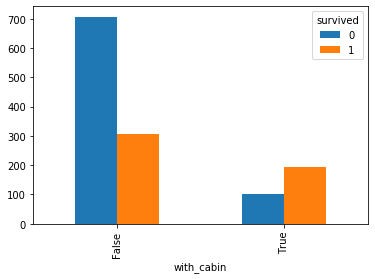

In [26]:
crosstab.plot.bar()
plt.show()

É possível colocar as barras empilhadas (**stacked**):

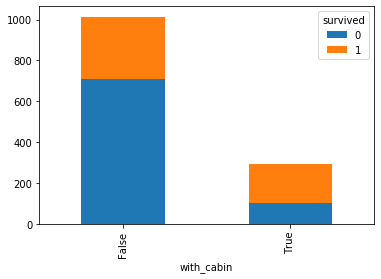

In [142]:
crosstab.plot.bar(stacked=True)
plt.show()

E existe outra maneira ainda mais simples de mostrar este gráfico...  
Usando o "**countplot**" da bibioteca **seaborn**.

In [28]:
import seaborn as sns

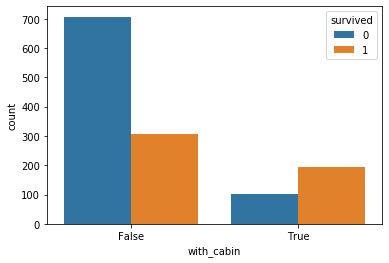

In [29]:
sns.countplot(x='with_cabin', hue='survived', data=df)
plt.show()

Vemos que não há relação aparente entre possuir cabine e sobreviver.  
Então como preencher os dados que faltam? 

<img src="images/icons8-balão-de-ar-quente-96.png" width="70">

Durante a análise, é comum ficar totalmente focado em um atributo de cada vez.  
Mas, de vez em quando, é importante se afastar do problema para recuperar a visão geral dos dados.

Isso favorece os *insights* 💡

Por exemplo...  
Cada passageiro tem um ticket e todos estão preenchidos...

In [30]:
df['ticket'].isnull().sum()

0

In [31]:
df['ticket'].value_counts()

CA. 2343        11
CA 2144          8
1601             8
PC 17608         7
S.O.C. 14879     7
                ..
693              1
315083           1
F.C. 12998       1
C.A. 5547        1
PC 17318         1
Name: ticket, Length: 939, dtype: int64

Alguns tickets estão repetidos.  
Talvez sejam crianças que receberam o mesmo número do ticket dos seus pais.  
Portanto, não é um problema.

<img src="images/icons8-dois-ingressos-96.png" width="80">

Criamos um dataframe somente dos tickets com cabines informadas (sem duplicidades):

In [143]:
df_tkt_cab = df[df.cabin.notnull()][['ticket', 'cabin']].drop_duplicates(subset='ticket')
df_tkt_cab

,ticket,cabin
0,24160,B5
1,113781,C22 C26
5,19952,E12
6,13502,D7
7,112050,A36
...,...,...
1131,SOTON/O.Q. 392078,E10
1187,PP 9549,G6
1217,348124,F G73
1230,347054,G6


Fazendo um join do dataframe principal com este...  
podemos preencher alguns números de cabine ausentes!

In [144]:
df_merge = df.merge(df_tkt_cab[['ticket', 'cabin']], how='left', on='ticket')
df_merge.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin_x,embarked,home.dest,with_cabin,cabin_y
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,"St Louis, MO",True,B5
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON",True,C22 C26
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON",True,C22 C26
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON",True,C22 C26
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,"Montreal, PQ / Chesterville, ON",True,C22 C26


In [145]:
df_merge.shape

(1309, 14)

Comparando a quantidade atual de cabines ausentes com a nova, após o join (merge).

In [147]:
print("Antes:", df['cabin'].isnull().sum())
print("Depois: ", df_merge['cabin_y'].isnull().sum())

Antes: 1014
Depois:  998


Vemos que 16 cabines foram preenchidas.

Passamos o resultado para o dataframe principal (df).

In [148]:
df = df_merge.drop('cabin_x', axis=1).rename({'cabin_y': 'cabin'}, axis=1)
df.columns

Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'embarked', 'home.dest', 'with_cabin', 'cabin'],
      dtype='object')

<img src="images/icons8-pensamento-crítico-96.png" width="70">

Mas ainda existem muitos dados ausentes de cabines.

In [150]:
df['cabin'].isnull().sum()

998

Como são os conteúdos das cabines preenchidas?

In [39]:
df['cabin'].unique()

array(['B5', 'C22 C26', 'E12', 'D7', 'A36', 'C101', nan, 'C62 C64', 'B35',
       'C46', 'A23', 'B58 B60', 'D15', 'C6', 'D35', 'C148', 'C97', 'B49',
       'C99', 'C52', 'T', 'A31', 'C7', 'C103', 'D22', 'B61', 'E33', 'A21',
       'B10', 'B4', 'E40', 'B38', 'E24', 'B51 B53 B55', 'B96 B98', 'E31',
       'E8', 'B77', 'A9', 'C89', 'A14', 'E58', 'E49', 'B22', 'B26', 'C85',
       'E17', 'B71', 'B20', 'A34', 'C86', 'A16', 'A20', 'A18', 'C54',
       'D20', 'A29', 'C68', 'E25', 'C111', 'C23 C25 C27', 'D34', 'D40',
       'B39', 'B41', 'B102', 'C123', 'E63', 'C130', 'B86', 'C92', 'A5',
       'C51', 'B42', 'C91', 'D10 D12', 'E50', 'D33', 'C83', 'B94', 'D45',
       'B69', 'B11', 'E46', 'C39', 'B18', 'D11', 'C93', 'B28', 'C49',
       'E60', 'B37', 'D21', 'D19', 'C124', 'D17', 'D28', 'D6', 'B80',
       'C106', 'B79', 'C47', 'D30', 'C90', 'E38', 'C78', 'C30', 'C118',
       'D36', 'D47', 'C105', 'B36', 'D43', 'C2', 'C104', 'C110', 'A24',
       'A32', 'A11', 'A10', 'E44', 'A26', 'A6', 'A7', '

O número da cabine é composto por um prefixo de uma letra seguido de um número.

In [40]:
df['cabin'].value_counts(dropna=False)

NaN            998
B61              7
C23 C25 C27      6
C22 C26          6
C78              5
              ... 
B4               1
B19              1
A36              1
F E57            1
T                1
Name: cabin, Length: 158, dtype: int64

In [41]:
df['cabin'].str[0].value_counts(dropna=False)

NaN    998
C      104
B       68
D       46
E       41
F       23
A       23
G        5
T        1
Name: cabin, dtype: int64

Uma ideia 💡   
Se essas letras representam uma espécie de categoria da cabine, podem estar relacionadas com outros dados.

Por exemplo, o atributo "**pclass**" indica a classe de viagem do passageiro.  

In [152]:
df['pclass'].value_counts()

3    709
1    323
2    277
Name: pclass, dtype: int64


São somente 3 valores distintos e todos preenchidos.  
Será que existe alguma relação entre as categorias das cabines (1a letra) e as classes de viagem?  

> **Obs:** Quando as variáveis são numéricas, é possível usar o método "**corr()**" do Pandas para obter as correlações entre elas.

Criamos uma nova coluna derivada para os prefixos das cabines.  
Colocamos algum caracter nos valores nulos, no caso, um "hífen".

In [154]:
df['cabin_prefix'] = df['cabin'].str[0].fillna('-')
df['cabin_prefix'].value_counts()

-    998
C    104
B     68
D     46
E     41
F     23
A     23
G      5
T      1
Name: cabin_prefix, dtype: int64

Agrupando por ambas as colunas (classe e categoria da cabine), calcula-se os totais para cada agrupamento.

In [155]:
df.groupby(['pclass', 'cabin_prefix'])['pclass'].count()

pclass  cabin_prefix
1       -                54
        A                23
        B                68
        C               104
        D                40
        E                33
        T                 1
2       -               253
        D                 6
        E                 5
        F                13
3       -               691
        E                 3
        F                10
        G                 5
Name: pclass, dtype: int64

Constatações e hipóteses a partir deste resultado:

1. A maioria das cabines não preenchidas (691) são da 3a classe.  
Parece indicar que os passageiros menos abastados não tinham direito a cabine, ou usavam uma cabine "coletiva".  
Ou até que a informação não foi preenchida por não ser relevante para a administração do navio.  
 * 1a classe: total 323; cabines não informadas 54  (16,7%)
 * 2a classe: total 277; cabines não informadas 253 (91,3%)
 * 3a classe: total 709; cabines não informadas 691 (97,4%)


2. As cabines tipo A, B e C são exclusivas da 1a classe.

3. A 2a classe usa cabines tipo D, E e F, também usadas nas 1a e 3a classes.

4. A cabine tipo G é exclusiva da 3a classe.

5. A cabine tipo T é também exclusiva da 1a classe, porém só um passageiro informou estar nela.

<img src="images/icons8-habilidade-de-brainstorm-96.png" width="80">

Mas será que existem cabines compartilhadas por passageiros de classes diferentes?

In [156]:
# Gera uma lista de cabines para cada classe
pc = (df[df['cabin'].notnull()]
        .groupby('pclass')['cabin']
        .unique()
        .reset_index())
pc

,pclass,cabin
0,1,"[B5, C22 C26, E12, D7, A36, C101, C62 C64, B35..."
1,2,"[D, F4, D56, F33, E101, E77, F2, D38, F]"
2,3,"[F G63, F E57, F E46, F G73, E121, F E69, E10,..."


In [157]:
# Separa as listas
pc_1 = list(pc.loc[0, 'cabin'])
pc_2 = list(pc.loc[1, 'cabin'])
pc_3 = list(pc.loc[2, 'cabin'])

In [158]:
# Retorna os elementos comuns (cabines) entre os conjuntos, se houverem.
print(set(pc_1) & set(pc_2))
print(set(pc_1) & set(pc_3))
print(set(pc_2) & set(pc_3))

set()
set()
set()


Nenhuma cabine em comum entre as classes!

Então, para preencher as cabines ausentes, basta escolher cabines aleatórias dentre as que estão ocupadas pelos passageiros da mesma classe.

In [159]:
import random

In [160]:
# Preenche cabines nulas da classe 1
mask = (df['pclass'] == 1) & (df['cabin'].isnull())
df.loc[mask, 'cabin'] = df.loc[mask, 'cabin'].apply(lambda x: random.choice(pc_1))
df[df['pclass'] == 1]['cabin'].isnull().sum()

0

In [161]:
# Preenche cabines nulas da classe 2
mask = (df['pclass'] == 2) & (df['cabin'].isnull())
df.loc[mask, 'cabin'] = df.loc[mask, 'cabin'].apply(lambda x: random.choice(pc_2))
df[df['pclass'] == 2]['cabin'].isnull().sum()

0

In [162]:
# Preenche cabines nulas da classe 3
mask = (df['pclass'] == 3) & (df['cabin'].isnull())
df.loc[mask, 'cabin'] = df.loc[mask, 'cabin'].apply(lambda x: random.choice(pc_3))
df[df['pclass'] == 3]['cabin'].isnull().sum()

0

In [163]:
df.cabin.isnull().sum()

0

#### Embarked
O atributo "embarked" informa o porto onde o passageiro embarcou (C = Cherbourg, Q = Queenstown, S = Southampton).

In [164]:
df['embarked'].value_counts()

S    914
C    270
Q    123
Name: embarked, dtype: int64

In [165]:
df['embarked'].isnull().sum()

2

Somente 2 ausentes.

A princípio, o porto de embarque não parece influenciar na possibilidade de sobrevivência.  
Conferimos isso graficamente:

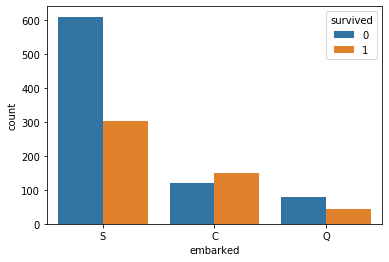

In [166]:
sns.countplot(x='embarked', hue='survived', data=df)
plt.show()

O percentual de sobrevivência é menor para os que embarcaram em Southampton, mas não parece uma regra.  
Chamaria a atenção se, por exemplo, todos os embarcados num porto tivessem morrido ou sobrevivido.  
Não é o caso.

Portanto, podemos preencher os ausentes com quaisquer dos valores ('S', 'C', ou 'Q').  
Vamos optar pelo **mais frequente** e usar novamente o SimpleImputer do scikit-learn.

In [167]:
imp = SimpleImputer(strategy='most_frequent')
df[['embarked']] = imp.fit_transform(df[['embarked']])
df['embarked'].isnull().sum()

0

<img src="images/icons8-navio-de-cruzeiro-96.png" width="80">

#### Home.Dest
O atributo "home.dest" informa as cidades natal e de destino.  
> **Obs:** Não existe no dataset do Kaggle.

In [168]:
df['home.dest'].isnull().agg(['sum', 'mean'])

sum     564.000000
mean      0.430863
Name: home.dest, dtype: float64

São 43% de dados não preenchidos, um percentual significativo.

In [169]:
df['home.dest'].value_counts()

New York, NY                    64
London                          14
Montreal, PQ                    10
Cornwall / Akron, OH             9
Paris, France                    9
                                ..
England New York, NY             1
England Salt Lake City, Utah     1
India / Rapid City, SD           1
Pomeroy, WA                      1
West Kensington, London          1
Name: home.dest, Length: 369, dtype: int64

Das cidades preenchidas, existem 369 combinações home/dest únicas, uma quantidade muito grande.

Como, aparentemente, uma barra (/) divide a cidade "home" da cidade "dest", é possível separá-las.

In [170]:
df['home.dest'].str.contains('/').value_counts(dropna=False)

False    574
NaN      564
True     171
Name: home.dest, dtype: int64

Com a parte antes da barra, sabemos quantas cidades natal distintas existem.

In [177]:
home = (df.loc[df['home.dest'].str.contains('/') == True, 'home.dest']
        .str.split('/')
        .apply(lambda d: d[0].strip())
       )
home.value_counts()

Cornwall                  19
London                    13
Paris                      9
England                    9
New York, NY               7
                          ..
Ascot, Berkshire           1
Liverpool, England         1
Goteborg, Sweden           1
Sittingbourne, England     1
Guernsey, England          1
Name: home.dest, Length: 66, dtype: int64

E com a parte após a barra, quantas cidades destino.

In [178]:
dest = (df.loc[df['home.dest'].str.contains('/') == True, 'home.dest']
        .str.split('/')
        .apply(lambda d: d[1].strip())
     )
dest.value_counts()

Akron, OH              11
New York, NY           10
Montreal, PQ            9
Detroit, MI             6
Cooperstown, NY         5
                       ..
Butte, MT               1
Briarcliff Manor NY     1
Belfast                 1
Birmingham              1
Hartford, CT            1
Name: home.dest, Length: 76, dtype: int64

Nenhuma das duas informações revelam algum *insight* sobre como preencher as lacunas.

Então, neste caso, é mais prudente remover a variável do que preenchê-la sem confiança.

In [181]:
df.drop('home.dest', axis=1, inplace=True)

In [182]:
df.notnull().sum()

pclass          1309
survived        1309
name            1309
sex             1309
age             1309
sibsp           1309
parch           1309
ticket          1309
fare            1309
embarked        1309
with_cabin      1309
cabin           1309
cabin_prefix    1309
dtype: int64

Pronto, não há mais dados ausentes no dataframe!

<img src="images/icons8-selecionado-96.png" width="70">

## Dez mandamentos

Ao final deste episódio, Learnison constatou que lidar com dados ausentes pode ser mais difícil do que se imagina.  
Existem muitas situações diferentes, assim como soluções específicas para cada caso.

Se as soluções foram as mais adequadas ou não, poderá descobrir só na etapa de construção do modelo.  
Mas, seja qual for o sucesso da modelagem, os seguintes "mandamentos" são uma boa referência.

1. ✅ Antes de qualquer coisa, conferir se os dados estão realmente ausentes.
    * Verificar se não houve perda de dados durante a transferência ou cópia do dataset.
    * Se o dataset passou por algum intermediário, checar também na origem.
    * Se veio de um banco de dados, consultar diretamente lá.
    * Averiguar se são dados pessoais ou sigilosos, protegidos por alguma lei ou questão ética.

2. 🚩 Resistir à tentação inicial de simplesmente remover as linhas e/ou colunas com lacunas de dados.

3. 👓 Reler, reler e reler as descrições dos atributos.  
Se houver dúvida, por menor que seja, consultar outras fontes até ter certeza do que se trata.  
Uma variável de aparência "inofensiva" poderá fazer muita falta posteriormente para o modelo.

4. 💦 Dispensar os atributos do tipo "vazamento" (*leaky features*) porque são resultados e, portanto, não servem como preditores.

5. ✏️ Para cada atributo, verificar as quantidades de lacunas, tanto em números absolutos quanto percentuais.  
Preparar-se para investir maior esforço nos atributos com maior percentual de ausências.

6. ✂️ Remover os dados ausentes, linhas ou colunas, conscientemente.  Ou seja, sabendo que:
    * não são importantes para o modelo, ou
    * são impraticáveis ou impossíveis de preencher de alguma maneira.

7. 🔍 Desvendar padrões de conteúdo nos atributos que possuem dados ausentes:
    * visualizar a distribuição com histogramas,
    * visualizar a densidade e esparsidade das lacunas por gráfico do tipo "matrix",
    * verificar a correlação com outros atributos e com o atributo-alvo:
        * considerando o conteúdo original,
        * considerando o conteúdo tratado (substring, split, lower/upper case, etc),
        * considerando o conteúdo derivado (function, expression, etc).

8. 💡 Insistir na observações de padrões e análise exploratória de forma que propicie:
    * melhor entendimento dos dados;
    * surgimento de ***insights*** que serão úteis tanto para o preenchimento das lacunas quanto para a posterior modelagem.

9. 🔮 Ao preencher os dados ausentes, resistir à tentação inicial de simplesmente atribuir um valor fixo.  
Considerar os diversos métodos possíveis:
    * se numérico: média, mediana, moda, etc.
    * se textual: mais frequente, dado tratado ou derivado de outros atributos ou de outro dataset,
    * se temporal: data ou hora derivadas de outros atributos ou de outro dataset.

10. 👽 E antes de comemorar o preenchimento (ou remoção) de todas as lacunas nos dados, é bom lembrar que existem dados "ausentes" disfarçados. Exemplos:
        * valores fora do escopo esperado (ex: negativos onde se esperam positivos)
        * textos com conteúdo do tipo: "Não Informado", "Não se Aplica", "Desconhecido", etc.
        * datas fictícias ou fora do escopo esperado (ex: 1900-01-01, 2010-00-00, 9999-09-09, etc.)